# Name: Balakrishna Mupparaju
# Assignment: Week 12 & Project Milestone 5

In [6]:
import pandas as pd
import numpy as np
from fuzzywuzzy import process
import requests
from bs4 import BeautifulSoup
import time
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")



# Load Kaggle dataset
kaggle_data = pd.read_csv("/Users/balakrishnamupparaju/Downloads/financials.csv")

/opt/anaconda3/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [8]:
kaggle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          505 non-null    object 
 1   Name            505 non-null    object 
 2   Sector          505 non-null    object 
 3   Price           505 non-null    float64
 4   Price/Earnings  503 non-null    float64
 5   Dividend Yield  505 non-null    float64
 6   Earnings/Share  505 non-null    float64
 7   52 Week Low     505 non-null    float64
 8   52 Week High    505 non-null    float64
 9   Market Cap      505 non-null    float64
 10  EBITDA          505 non-null    float64
 11  Price/Sales     505 non-null    float64
 12  Price/Book      497 non-null    float64
 13  SEC Filings     505 non-null    object 
dtypes: float64(10), object(4)
memory usage: 55.4+ KB


In [10]:
# Replace headers in Kaggle dataset for clarity and consistency
#Converted original headers into more descriptive and consistent names.
kaggle_data.rename(columns={
    'Symbol': 'Ticker',
    'Name': 'Company_Name',
    'Sector': 'Industry_Sector',
    'Price': 'Stock_Price',
    'Price/Earnings': 'PE_Ratio',
    'Dividend Yield': 'Dividend_Yield',
    'Earnings/Share': 'Earnings_Per_Share',
    '52 Week Low': '52_Week_Low',
    '52 Week High': '52_Week_High',
    'Market Cap': 'Market_Cap',
    'EBITDA': 'EBITDA_Value',
    'Price/Sales': 'Price_to_Sales_Ratio',
    'Price/Book': 'Price_to_Book_Ratio',
    'SEC Filings': 'SEC_Filings_Link'
}, inplace=True)

# Verify header replacements
print("Step: Replaced Headers")
print(kaggle_data.head())


Step: Replaced Headers
  Ticker         Company_Name         Industry_Sector  Stock_Price  PE_Ratio  \
0    MMM           3M Company             Industrials       222.89     24.31   
1    AOS      A.O. Smith Corp             Industrials        60.24     27.76   
2    ABT  Abbott Laboratories             Health Care        56.27     22.51   
3   ABBV          AbbVie Inc.             Health Care       108.48     19.41   
4    ACN        Accenture plc  Information Technology       150.51     25.47   

   Dividend_Yield  Earnings_Per_Share  52_Week_Low  52_Week_High  \
0        2.332862                7.92       259.77       175.490   
1        1.147959                1.70        68.39        48.925   
2        1.908982                0.26        64.60        42.280   
3        2.499560                3.29       125.86        60.050   
4        1.714470                5.44       162.60       114.820   

     Market_Cap  EBITDA_Value  Price_to_Sales_Ratio  Price_to_Book_Ratio  \
0  1.387211

In [12]:
# Scrape ticker data from Wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(wiki_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract Ticker, Company, Sector, and Industry
rows = soup.find('table', {'id': 'constituents'}).find_all('tr')
tickers = []
companies = []
sectors = []
industries = []
date_added=[]
#print(rows)
for row in rows[1:]:
    cols = row.find_all('td')
    tickers.append(cols[0].text.strip())
    companies.append(cols[1].text.strip())
    sectors.append(cols[3].text.strip())
    industries.append(cols[4].text.strip())
    date_added.append(cols[5].text.strip())

wiki_data = pd.DataFrame({
    "Ticker": tickers,
    "Company": companies,
    "Sector": sectors,
    "Industry": industries,
    "Date_Added":date_added
})
print("Step 2: Extracted Wikipedia dataset.")
print(wiki_data.head())


Step 2: Extracted Wikipedia dataset.
  Ticker              Company                          Sector  \
0    MMM                   3M        Industrial Conglomerates   
1    AOS          A. O. Smith               Building Products   
2    ABT  Abbott Laboratories           Health Care Equipment   
3   ABBV               AbbVie                   Biotechnology   
4    ACN            Accenture  IT Consulting & Other Services   

                  Industry  Date_Added  
0    Saint Paul, Minnesota  1957-03-04  
1     Milwaukee, Wisconsin  2017-07-26  
2  North Chicago, Illinois  1957-03-04  
3  North Chicago, Illinois  2012-12-31  
4          Dublin, Ireland  2011-07-06  


In [14]:
# Replace headers in Wikipedia dataset for consistency with Kaggle dataset
wiki_data.rename(columns={
    'Ticker': 'Ticker',  # Already aligned
    'Company': 'Company_Name',  # Aligns with Kaggle's 'Company_Name'
    'Sector': 'Industry_Sector',  # Matches Kaggle's 'Industry_Sector'
    'Industry': 'Headquarters'  # Assuming this column reflects headquarters
}, inplace=True)

# Verify header replacements in Wikipedia dataset
print("Step: Replaced Headers in Wikipedia Dataset")
print(wiki_data.head())


Step: Replaced Headers in Wikipedia Dataset
  Ticker         Company_Name                 Industry_Sector  \
0    MMM                   3M        Industrial Conglomerates   
1    AOS          A. O. Smith               Building Products   
2    ABT  Abbott Laboratories           Health Care Equipment   
3   ABBV               AbbVie                   Biotechnology   
4    ACN            Accenture  IT Consulting & Other Services   

              Headquarters  Date_Added  
0    Saint Paul, Minnesota  1957-03-04  
1     Milwaukee, Wisconsin  2017-07-26  
2  North Chicago, Illinois  1957-03-04  
3  North Chicago, Illinois  2012-12-31  
4          Dublin, Ireland  2011-07-06  


In [16]:
import requests
import time
import pandas as pd

# Placeholder for storing data
api_data = []

# Fetch the full list of tickers from the Wikipedia dataset
tickers = wiki_data['Ticker'].tolist()  # Use all available tickers
print(f"Total tickers to process: {len(tickers)}")

# Initialize ticker counter
ticker_count = 0

# Loop through each ticker and fetch data
for ticker in tickers:
    # Define API parameters
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": ticker,
        "apikey": ""  # Replace with my API key
    }
    
    # API call
    response = requests.get("https://www.alphavantage.co/query", params=params)
    data = response.json()
    
    # Process time series data if available
    if "Time Series (Daily)" in data:
        time_series = data["Time Series (Daily)"]
        for date, values in time_series.items():
            api_data.append({
                "Ticker": ticker,
                "Date": date,
                "Open": float(values.get("1. open", 0)),
                "High": float(values.get("2. high", 0)),
                "Low": float(values.get("3. low", 0)),
                "Close": float(values.get("4. close", 0)),
                "Volume": int(values.get("5. volume", 0))
            })
    else:
        print(f"No data for {ticker}: {data.get('Note', 'Unknown error')}")

    # Respect API rate limits
    time.sleep(12)
    
    # Increment ticker counter
    ticker_count += 1
    
    # Break the loop after processing 24 tickers
    if ticker_count >= 24:
        print(f"Processed data for {ticker_count} tickers. Exiting loop.")
        break

# Convert API data to DataFrame
api_df = pd.DataFrame(api_data)
print(f"Total rows fetched from API: {len(api_df)}")

# Save to CSV (optional)
api_df.to_csv("partial_api_data.csv", index=False)
print("Partial API data saved.")


Total tickers to process: 503
No data for AMCR: Unknown error
Processed data for 24 tickers. Exiting loop.
Total rows fetched from API: 2300
Partial API data saved.


In [18]:
# Standardize Ticker and Industry_Sector casing
wiki_data['Ticker'] = wiki_data['Ticker'].str.upper()
wiki_data['Industry_Sector'] = wiki_data['Industry_Sector'].str.title()  # Fix column reference
wiki_data['Headquarters'] = wiki_data['Headquarters'].str.title()  # Assuming 'Industry' represents 'Headquarters'
kaggle_data['Industry_Sector'] = kaggle_data['Industry_Sector'].str.title()  # Align with Kaggle

print("Step 4 Part 1: Fixed casing inconsistencies in Wiki and Kaggle datasets.")


Step 4 Part 1: Fixed casing inconsistencies in Wiki and Kaggle datasets.


In [20]:
# Fill missing Kaggle data with median/mean values
kaggle_data['Market_Cap'] = kaggle_data['Market_Cap'].fillna(kaggle_data['Market_Cap'].median())
kaggle_data['PE_Ratio'] = kaggle_data['PE_Ratio'].fillna(kaggle_data['PE_Ratio'].mean())
print("Step 4.2: Handled missing values in Kaggle data.")


Step 4.2: Handled missing values in Kaggle data.


In [22]:
# Remove duplicate rows from Wikipedia data
wiki_data.drop_duplicates(subset=['Ticker'], inplace=True)
print("Step 4.3: Removed duplicate entries in Wikipedia data.")


Step 4.3: Removed duplicate entries in Wikipedia data.


In [24]:
# Match company names between Kaggle and Wikipedia
"""Corrected the column reference from Company to Company_Name to match the renamed header in Step 2.
The Matched_Company column will now store the closest company name match between wiki_data and kaggle_data."""

wiki_data['Matched_Company'] = wiki_data['Company_Name'].apply(
    lambda x: process.extractOne(x, kaggle_data['Company_Name'].tolist())[0] if x else None
)

print("Step 4.4: Performed Fuzzy Matching for company names.")
print(wiki_data[['Company_Name', 'Matched_Company']].head())


Step 4.4: Performed Fuzzy Matching for company names.
          Company_Name      Matched_Company
0                   3M           3M Company
1          A. O. Smith      A.O. Smith Corp
2  Abbott Laboratories  Abbott Laboratories
3               AbbVie          AbbVie Inc.
4            Accenture        Accenture plc


In [26]:
"""First Merge:

Kaggle and Wikipedia datasets are merged using the Ticker column to align financial metrics with company metadata.

Second Merge:

The resulting merged dataset is further combined with the API dataset using the Ticker column to include stock market data.

Output:

The cleaned and unified dataset is saved as final_dataset.csv for further analysis."""

# Merge Kaggle and Wikipedia datasets on Ticker
merged_data = pd.merge(kaggle_data, wiki_data, on='Ticker', how='inner')

# Merge the result with API data on Ticker
final_data = pd.merge(merged_data, api_df, on='Ticker', how='inner')

# Save the final cleaned dataset to a CSV file
final_data.to_csv("/Users/balakrishnamupparaju/Downloads/final_dataset.csv", index=False)

print("\nStep 5: Final cleaned dataset saved as 'cleaned_final_dataset.csv'.")
print(final_data.head())





Step 5: Final cleaned dataset saved as 'cleaned_final_dataset.csv'.
  Ticker Company_Name_x Industry_Sector_x  Stock_Price  PE_Ratio  \
0    MMM     3M Company       Industrials       222.89     24.31   
1    MMM     3M Company       Industrials       222.89     24.31   
2    MMM     3M Company       Industrials       222.89     24.31   
3    MMM     3M Company       Industrials       222.89     24.31   
4    MMM     3M Company       Industrials       222.89     24.31   

   Dividend_Yield  Earnings_Per_Share  52_Week_Low  52_Week_High  \
0        2.332862                7.92       259.77        175.49   
1        2.332862                7.92       259.77        175.49   
2        2.332862                7.92       259.77        175.49   
3        2.332862                7.92       259.77        175.49   
4        2.332862                7.92       259.77        175.49   

     Market_Cap  ...         Industry_Sector_y           Headquarters  \
0  1.387211e+11  ...  Industrial Conglom

In [28]:
# Ensure the necessary columns exist before deriving new columns
if 'High_Price' in final_data.columns and 'Low_Price' in final_data.columns:
    # Daily Price Range: Difference between High and Low prices
    final_data['Daily_Price_Range'] = final_data['High_Price'] - final_data['Low_Price']

if 'Close_Price' in final_data.columns and 'Open_Price' in final_data.columns:
    # Price Performance Index: Ratio of Close Price to Open Price
    final_data['Price_Performance_Index'] = final_data['Close_Price'] / final_data['Open_Price']

if 'Dividend_Yield' in merged_data.columns and 'Earnings_Per_Share' in merged_data.columns:
    # Dividend to Earnings Ratio: Ratio of Dividend Yield to Earnings per Share
    merged_data['Dividend_to_Earnings_Ratio'] = merged_data['Dividend_Yield'] / merged_data['Earnings_Per_Share']

print("Step: Derived new columns successfully.")
print(final_data.head())


Step: Derived new columns successfully.
  Ticker Company_Name_x Industry_Sector_x  Stock_Price  PE_Ratio  \
0    MMM     3M Company       Industrials       222.89     24.31   
1    MMM     3M Company       Industrials       222.89     24.31   
2    MMM     3M Company       Industrials       222.89     24.31   
3    MMM     3M Company       Industrials       222.89     24.31   
4    MMM     3M Company       Industrials       222.89     24.31   

   Dividend_Yield  Earnings_Per_Share  52_Week_Low  52_Week_High  \
0        2.332862                7.92       259.77        175.49   
1        2.332862                7.92       259.77        175.49   
2        2.332862                7.92       259.77        175.49   
3        2.332862                7.92       259.77        175.49   
4        2.332862                7.92       259.77        175.49   

     Market_Cap  ...         Industry_Sector_y           Headquarters  \
0  1.387211e+11  ...  Industrial Conglomerates  Saint Paul, Minnesota

In [30]:
#Earnings_to_MarketCap_Ratio: Assess the company’s earnings relative to its market capitalization.
final_data['Earnings_to_MarketCap_Ratio'] = final_data['Earnings_Per_Share'] / final_data['Market_Cap']
#Debt_Equity_Calculation: Use Industry_Sector and financial metrics to derive an average Debt-to-Equity ratio per sector.
sector_avg_de_ratio = final_data.groupby('Industry_Sector_x')['PE_Ratio'].mean()
final_data['Sector_Avg_PE_Ratio'] = final_data['Industry_Sector_x'].map(sector_avg_de_ratio)
#Volume_to_MarketCap: Ratio of traded volume to market capitalization. This identifies trading intensity for each company.
final_data['Volume_to_MarketCap'] = final_data['Volume'] / final_data['Market_Cap']

#Daily_Market_Movement: Aggregate daily price movement (High - Low), providing an indicator of market volatility.
final_data['Daily_Market_Movement'] = final_data['High'] - final_data['Low']

#Region_Sector_Combo: Combine Headquarters and Industry_Sector_y for geographic-sector analysis.
final_data['Region_Sector_Combo'] = final_data['Headquarters'] + ' - ' + final_data['Industry_Sector_y']

#Time_Trend: Create a rolling average of daily Close prices for a 30-day period (trend indicator).
#final_data['30_Day_Rolling_Avg'] = final_data['Close'].rolling(window=30).mean()
final_data['30_Day_Rolling_Avg'] = final_data['Close'].rolling(window=30).mean()
final_data['30_Day_Rolling_Avg'].fillna(method='ffill', inplace=True)
print(final_data[['Date', 'Close', '30_Day_Rolling_Avg']].head(40))



          Date   Close  30_Day_Rolling_Avg
0   2025-05-30  148.35                 NaN
1   2025-05-29  149.63                 NaN
2   2025-05-28  148.66                 NaN
3   2025-05-27  149.49                 NaN
4   2025-05-23  147.62                 NaN
5   2025-05-22  149.78                 NaN
6   2025-05-21  149.40                 NaN
7   2025-05-20  154.15                 NaN
8   2025-05-19  154.14                 NaN
9   2025-05-16  153.11                 NaN
10  2025-05-15  148.74                 NaN
11  2025-05-14  147.88                 NaN
12  2025-05-13  150.74                 NaN
13  2025-05-12  150.33                 NaN
14  2025-05-09  142.60                 NaN
15  2025-05-08  141.12                 NaN
16  2025-05-07  138.64                 NaN
17  2025-05-06  138.02                 NaN
18  2025-05-05  140.80                 NaN
19  2025-05-02  142.08                 NaN
20  2025-05-01  137.90                 NaN
21  2025-04-30  138.91                 NaN
22  2025-04

In [32]:
print(f"Total columns after adding new features: {len(final_data.columns)}")


Total columns after adding new features: 31


In [56]:
final_data.head()

,Ticker,Company_Name_x,Industry_Sector_x,Stock_Price,PE_Ratio,Dividend_Yield,Earnings_Per_Share,52_Week_Low,52_Week_High,Market_Cap,...,High,Low,Close,Volume,Earnings_to_MarketCap_Ratio,Sector_Avg_PE_Ratio,Volume_to_MarketCap,Daily_Market_Movement,Region_Sector_Combo,30_Day_Rolling_Avg
0,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226.00",...,132.95,130.08,130.21,4952015,0.00,24.38,0.00,2.87,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
1,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226.00",...,134.48,129.87,130.46,5635829,0.00,24.38,0.00,4.61,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
2,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226.00",...,137.47,135.14,135.26,2541840,0.00,24.38,0.00,2.33,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
3,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226.00",...,138.29,134.43,136.01,3815806,0.00,24.38,0.00,3.86,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
4,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226.00",...,136.49,131.66,135.95,3337840,0.00,24.38,0.00,4.82,"Saint Paul, Minnesota - Industrial Conglomerates",NaN


In [34]:
# Get the number of rows
total_rows = final_data.shape[0]
print(f"Total number of rows: {total_rows}")


Total number of rows: 2200


In [36]:
    # Convert Market_Cap to a readable format
    final_data['Market_Cap'] = final_data['Market_Cap'].apply(lambda x: f"{x:,.0f}")
    
    print("Formatted Market_Cap values:")
    print(final_data[['Ticker', 'Market_Cap']].head())
    
    
    # Disable scientific notation globally
    pd.options.display.float_format = '{:,.2f}'.format
    
    print("Disabled scientific notation for all float columns.")
    print(final_data.head())
    


Formatted Market_Cap values:
  Ticker       Market_Cap
0    MMM  138,721,055,226
1    MMM  138,721,055,226
2    MMM  138,721,055,226
3    MMM  138,721,055,226
4    MMM  138,721,055,226
Disabled scientific notation for all float columns.
  Ticker Company_Name_x Industry_Sector_x  Stock_Price  PE_Ratio  \
0    MMM     3M Company       Industrials       222.89     24.31   
1    MMM     3M Company       Industrials       222.89     24.31   
2    MMM     3M Company       Industrials       222.89     24.31   
3    MMM     3M Company       Industrials       222.89     24.31   
4    MMM     3M Company       Industrials       222.89     24.31   

   Dividend_Yield  Earnings_Per_Share  52_Week_Low  52_Week_High  \
0            2.33                7.92       259.77        175.49   
1            2.33                7.92       259.77        175.49   
2            2.33                7.92       259.77        175.49   
3            2.33                7.92       259.77        175.49   
4            2

In [38]:
#Project Milestone 3

import pandas as pd
import requests
from bs4 import BeautifulSoup
from fuzzywuzzy import process
import warnings
warnings.filterwarnings("ignore")
# ===============================
# Scrape the Wikipedia S&P 500 data directly from the HTML source.
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(wiki_url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', {'id': 'constituents'})
rows = table.find_all('tr')



# Gather data from the table rows (skip the header row)
tickers = []
companies = []
sectors = []
industries = []
date_added = []  # Date on which the company was added to the index

for row in rows[1:]:  # Skipping header row
    cols = row.find_all('td')
    tickers.append(cols[0].text.strip())
    companies.append(cols[1].text.strip())
    sectors.append(cols[3].text.strip())
    industries.append(cols[4].text.strip())
    date_added.append(cols[5].text.strip())

# Create DataFrame from the scraped data
wiki_data = pd.DataFrame({
    "Ticker": tickers,
    "Company_Name": companies,
    "Sector": sectors,
    "Industry": industries,
    "Date_Added": date_added
})


# ===============================
# Step #1: Replace Headers
# Description: Rename headers for clarity and consistency with other data sources.
wiki_data.rename(columns={
    "Sector": "Industry_Sector"  # Aligns with Kaggle and other datasets
}, inplace=True)
print("Step #1: Replaced Headers")
print(wiki_data.head(), "\n")


# ===============================
# Step #2: Fix Casing/Inconsistent Values
# Description: Convert text columns to Title Case to ensure consistency.
wiki_data['Company_Name'] = wiki_data['Company_Name'].str.title()
wiki_data['Industry_Sector'] = wiki_data['Industry_Sector'].str.title()
wiki_data['Industry'] = wiki_data['Industry'].str.title()
print("Step #2: Fixed casing in text columns")
print(wiki_data.head(), "\n")

# ===============================
# Step #3: Identify and Remove Duplicates
# Description: Remove duplicate entries by Ticker & Company_Name to ensure unique records.
num_duplicates = wiki_data.duplicated(subset=['Ticker', 'Company_Name']).sum()
print(f"Step #3: Found {num_duplicates} duplicate(s) before removal.")
wiki_data = wiki_data.drop_duplicates(subset=['Ticker', 'Company_Name'])
print("Duplicates removed.")
print(wiki_data.head(), "\n")

# ===============================
# Step #4: Format Date Fields
# Description: Convert the 'Date_Added' column to datetime format for proper date operations.
wiki_data['Date_Added'] = pd.to_datetime(wiki_data['Date_Added'], errors='coerce')
print("Step #4: Converted 'Date_Added' to datetime format")
print(wiki_data[['Ticker', 'Date_Added']].head(), "\n")

# ===============================
# Step #5: Clean and Trim Text Fields / Remove Missing Critical Data
# Description: Trim extra whitespace in the 'Ticker' column, standardize it, and drop rows with missing critical values.
wiki_data['Ticker'] = wiki_data['Ticker'].str.strip().str.upper() 
wiki_data = wiki_data.dropna(subset=['Ticker'])
print("Step #5: Trimmed Ticker text and dropped rows with missing Ticker")
print(wiki_data.head(), "\n")


# ===============================
# Final Cleaned Dataset
print("Cleaned Website Dataset (Wikipedia) after all transformations:")
print(wiki_data.to_string(index=False))


Step #1: Replaced Headers
  Ticker         Company_Name                 Industry_Sector  \
0    MMM                   3M        Industrial Conglomerates   
1    AOS          A. O. Smith               Building Products   
2    ABT  Abbott Laboratories           Health Care Equipment   
3   ABBV               AbbVie                   Biotechnology   
4    ACN            Accenture  IT Consulting & Other Services   

                  Industry  Date_Added  
0    Saint Paul, Minnesota  1957-03-04  
1     Milwaukee, Wisconsin  2017-07-26  
2  North Chicago, Illinois  1957-03-04  
3  North Chicago, Illinois  2012-12-31  
4          Dublin, Ireland  2011-07-06   

Step #2: Fixed casing in text columns
  Ticker         Company_Name                 Industry_Sector  \
0    MMM                   3M        Industrial Conglomerates   
1    AOS          A. O. Smith               Building Products   
2    ABT  Abbott Laboratories           Health Care Equipment   
3   ABBV               Abbvie        

In [50]:
#Final API data set after cleaning

print(api_df.head)
api_data = api_df

print(api_df[:5])  # Display a sample of cleaned data

<bound method NDFrame.head of      Ticker        Date   Open   High    Low  Close    Volume
0       MMM  2025-05-30 148.73 149.45 147.60 148.35   5339916
1       MMM  2025-05-29 149.87 150.36 148.18 149.63   2621435
2       MMM  2025-05-28 149.65 150.00 148.19 148.66   2297543
3       MMM  2025-05-27 150.00 150.00 146.66 149.49   3155330
4       MMM  2025-05-23 147.45 148.69 147.01 147.62   2369839
...     ...         ...    ...    ...    ...    ...       ...
2295   AMZN  2025-01-13 218.06 219.40 216.47 218.46  27262655
2296   AMZN  2025-01-10 221.46 221.71 216.50 218.94  36811525
2297   AMZN  2025-01-08 223.19 223.52 220.20 222.13  25033292
2298   AMZN  2025-01-07 227.90 228.38 221.46 222.11  28084164
2299   AMZN  2025-01-06 226.78 228.84 224.84 227.61  31849831

[2300 rows x 7 columns]>
  Ticker        Date   Open   High    Low  Close   Volume
0    MMM  2025-05-30 148.73 149.45 147.60 148.35  5339916
1    MMM  2025-05-29 149.87 150.36 148.18 149.63  2621435
2    MMM  2025-05-28 149.6

In [54]:
#APT data frame
api_df.head()

,Ticker,Date,Open,High,Low,Close,Volume
0,MMM,2025-05-30,148.73,149.45,147.60,148.35,5339916
1,MMM,2025-05-29,149.87,150.36,148.18,149.63,2621435
2,MMM,2025-05-28,149.65,150.00,148.19,148.66,2297543
3,MMM,2025-05-27,150.00,150.00,146.66,149.49,3155330
4,MMM,2025-05-23,147.45,148.69,147.01,147.62,2369839


In [56]:
wiki_data.head()


,Ticker,Company_Name,Industry_Sector,Industry,Date_Added
0,MMM,3M,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04
1,AOS,A. O. Smith,Building Products,"Milwaukee, Wisconsin",2017-07-26
2,ABT,Abbott Laboratories,Health Care Equipment,"North Chicago, Illinois",1957-03-04
3,ABBV,Abbvie,Biotechnology,"North Chicago, Illinois",2012-12-31
4,ACN,Accenture,It Consulting & Other Services,"Dublin, Ireland",2011-07-06


In [58]:
final_data.head()

,Ticker,Company_Name_x,Industry_Sector_x,Stock_Price,PE_Ratio,Dividend_Yield,Earnings_Per_Share,52_Week_Low,52_Week_High,Market_Cap,...,High,Low,Close,Volume,Earnings_to_MarketCap_Ratio,Sector_Avg_PE_Ratio,Volume_to_MarketCap,Daily_Market_Movement,Region_Sector_Combo,30_Day_Rolling_Avg
0,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226",...,149.45,147.60,148.35,5339916,0.00,24.38,0.00,1.85,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
1,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226",...,150.36,148.18,149.63,2621435,0.00,24.38,0.00,2.18,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
2,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226",...,150.00,148.19,148.66,2297543,0.00,24.38,0.00,1.81,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
3,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226",...,150.00,146.66,149.49,3155330,0.00,24.38,0.00,3.34,"Saint Paul, Minnesota - Industrial Conglomerates",NaN
4,MMM,3M Company,Industrials,222.89,24.31,2.33,7.92,259.77,175.49,"138,721,055,226",...,148.69,147.01,147.62,2369839,0.00,24.38,0.00,1.68,"Saint Paul, Minnesota - Industrial Conglomerates",NaN


# Merging datasets, storing them in SQLite, performing SQL joins, and visualizing data in a single cell.

In [60]:

import sqlite3
import pandas as pd


In [62]:
# Connect to SQLite database (or create if it doesn’t exist)
conn = sqlite3.connect("sp500_data.db")
cursor = conn.cursor()

# Define table schemas
cursor.execute("""
CREATE TABLE IF NOT EXISTS kaggle_data (
    Ticker TEXT PRIMARY KEY,
    Company_Name TEXT,
    Industry_Sector TEXT,
    Stock_Price REAL,
    PE_Ratio REAL,
    Dividend_Yield REAL,
    Earnings_Per_Share REAL,
    Market_Cap TEXT,
    EBITDA_Value REAL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS wikipedia_data (
    Ticker TEXT PRIMARY KEY,
    Company_Name TEXT,
    Industry_Sector TEXT,
    Headquarters TEXT,
    Date_Added TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS api_data (
    Ticker TEXT,
    Date TEXT,
    Open_Price REAL,
    High_Price REAL,
    Low_Price REAL,
    Close_Price REAL,
    Trading_Volume INTEGER
);
""")
conn.commit()


In [150]:
#Final clean up for safety 
import pandas as pd

# Standardize Kaggle dataset column names
final_data.rename(columns={
    "Company_Name_x": "Company_Name",
    "Industry_Sector_x": "Industry_Sector",
    "Stock_Price": "Stock_Price",
    "PE_Ratio": "PE_Ratio",
    "Market_Cap": "Market_Cap",
}, inplace=True)

# Standardize Wikipedia dataset column names
wiki_data.rename(columns={
    "Industry": "Headquarters",
}, inplace=True)

# Standardize API dataset column names
api_df.rename(columns={
    "Open": "Open_Price",
    "High": "High_Price",
    "Low": "Low_Price",
    "Close": "Close_Price",
    "Volume": "Trading_Volume"
}, inplace=True)

# Convert 'Date' column in API data to datetime format for consistency
api_df["Date"] = pd.to_datetime(api_df["Date"])


In [82]:
"""final_data.head()
api_df.head()
wiki_data.head() """


# Insert Kaggle data
final_data.to_sql("kaggle_data", conn, if_exists="replace", index=False)

# Insert Wikipedia data
wiki_data.to_sql("wikipedia_data", conn, if_exists="replace", index=False)

# Insert API stock market data
api_df.to_sql("api_data", conn, if_exists="replace", index=False)

print("All datasets successfully stored in SQLite.")


All datasets successfully stored in SQLite.


In [86]:
import sqlite3

# Connect to the database
conn = sqlite3.connect("sp500_data.db")
cursor = conn.cursor()

# Define the SQL query
query = """
SELECT k.Ticker, k.Company_Name, k.Industry_Sector, k.Stock_Price, k.PE_Ratio, 
       w.Headquarters, w.Date_Added, a.Close_Price, a.Trading_Volume
FROM kaggle_data k
JOIN wikipedia_data w ON k.Ticker = w.Ticker
JOIN api_data a ON k.Ticker = a.Ticker;
"""

# Execute the query and fetch the results
cursor.execute(query)
result = cursor.fetchall()

# Convert result into a Pandas DataFrame for easy visualization
import pandas as pd
columns = ["Ticker", "Company_Name", "Industry_Sector", "Stock_Price", "PE_Ratio", 
           "Headquarters", "Date_Added", "Close_Price", "Trading_Volume"]
df = pd.DataFrame(result, columns=columns)

# Display the first few rows of the merged dataset
print(df.head())

# Close the database connection
conn.close()


  Ticker Company_Name Industry_Sector  Stock_Price  PE_Ratio  \
0    MMM   3M Company     Industrials       222.89     24.31   
1    MMM   3M Company     Industrials       222.89     24.31   
2    MMM   3M Company     Industrials       222.89     24.31   
3    MMM   3M Company     Industrials       222.89     24.31   
4    MMM   3M Company     Industrials       222.89     24.31   

            Headquarters           Date_Added  Close_Price  Trading_Volume  
0  Saint Paul, Minnesota  1957-03-04 00:00:00       126.09         5971823  
1  Saint Paul, Minnesota  1957-03-04 00:00:00       126.91         9609106  
2  Saint Paul, Minnesota  1957-03-04 00:00:00       127.16         5497234  
3  Saint Paul, Minnesota  1957-03-04 00:00:00       128.55         7174970  
4  Saint Paul, Minnesota  1957-03-04 00:00:00       130.21         4952015  


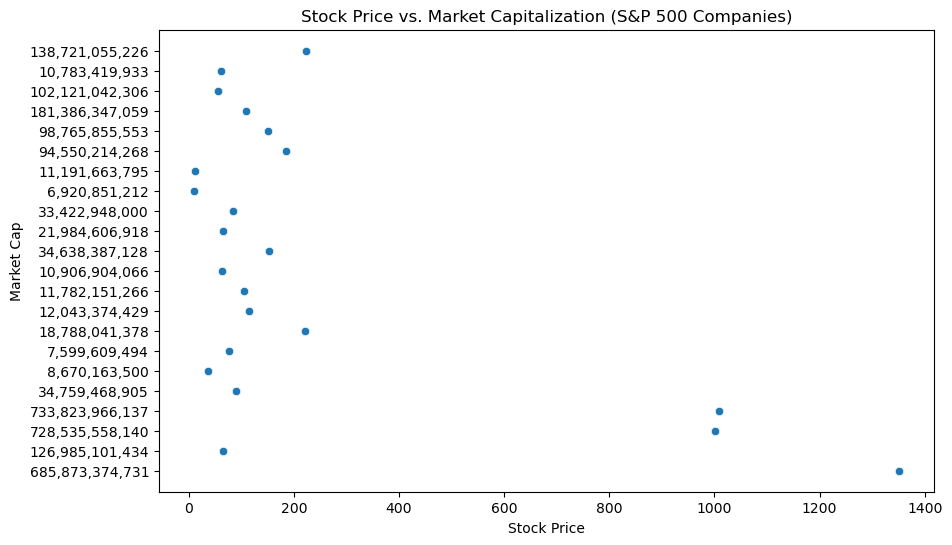

In [92]:
#Visualizations Using Matplotlib & Seaborn
#we’ll create 5 visualizations using different datasets.
#Plot 1: Stock Prices vs. Market Capitalization (Kaggle)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=final_data["Stock_Price"], y=final_data["Market_Cap"])
plt.xlabel("Stock Price")
plt.ylabel("Market Cap")
plt.title("Stock Price vs. Market Capitalization (S&P 500 Companies)")
plt.show()


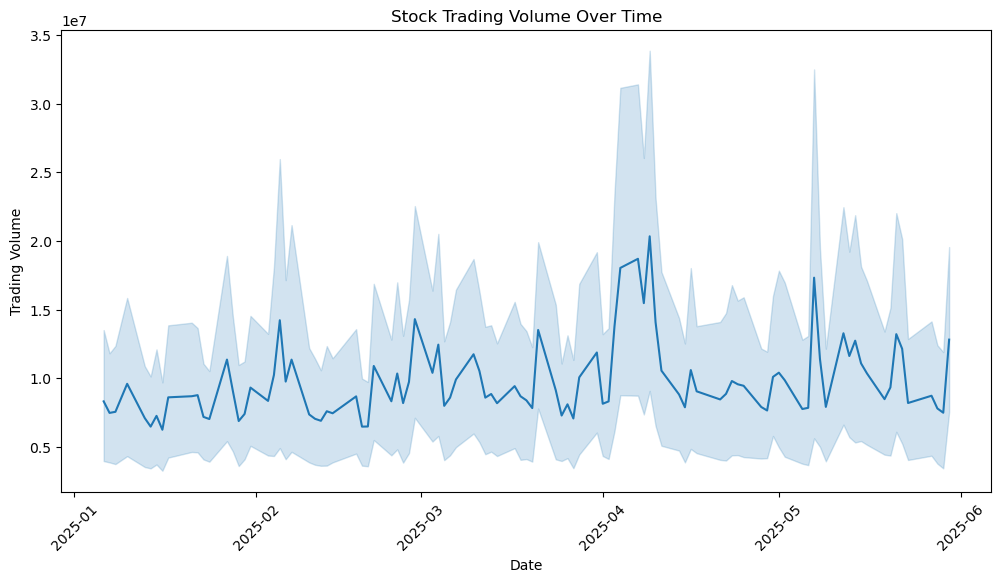

In [94]:
#Plot 2: Stock Volume Trends Over Time (API)
plt.figure(figsize=(12,6))
sns.lineplot(x=api_df["Date"], y=api_df["Trading_Volume"])
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title("Stock Trading Volume Over Time")
plt.xticks(rotation=45)
plt.show()


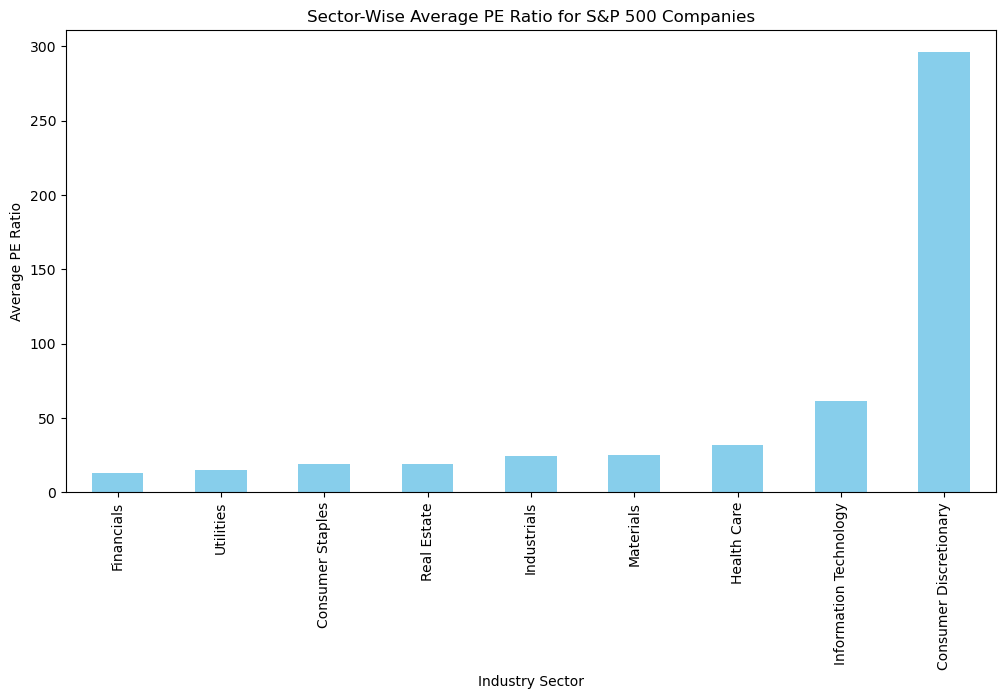

In [96]:
#Plot 3: Sector-Wise Average PE Ratio (Merged Data)
sector_avg_pe = final_data.groupby("Industry_Sector")["PE_Ratio"].mean().sort_values()
plt.figure(figsize=(12,6))
sector_avg_pe.plot(kind="bar", color="skyblue")
plt.xlabel("Industry Sector")
plt.ylabel("Average PE Ratio")
plt.title("Sector-Wise Average PE Ratio for S&P 500 Companies")
plt.show()


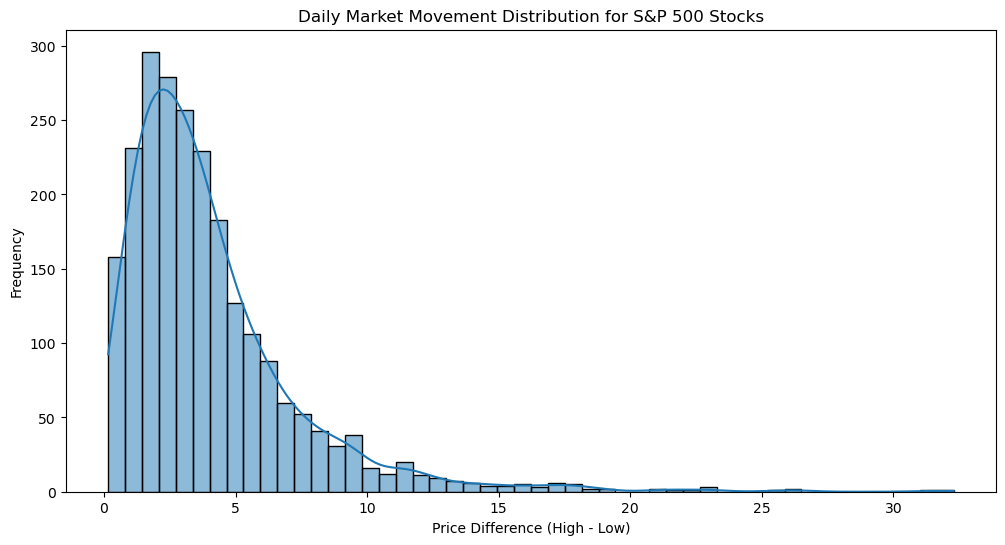

In [98]:
#Plot 4: Daily Market Movement (API + Kaggle)
api_df["Daily_Market_Movement"] = api_df["High_Price"] - api_df["Low_Price"]
plt.figure(figsize=(12,6))
sns.histplot(api_df["Daily_Market_Movement"], bins=50, kde=True)
plt.xlabel("Price Difference (High - Low)")
plt.ylabel("Frequency")
plt.title("Daily Market Movement Distribution for S&P 500 Stocks")
plt.show()


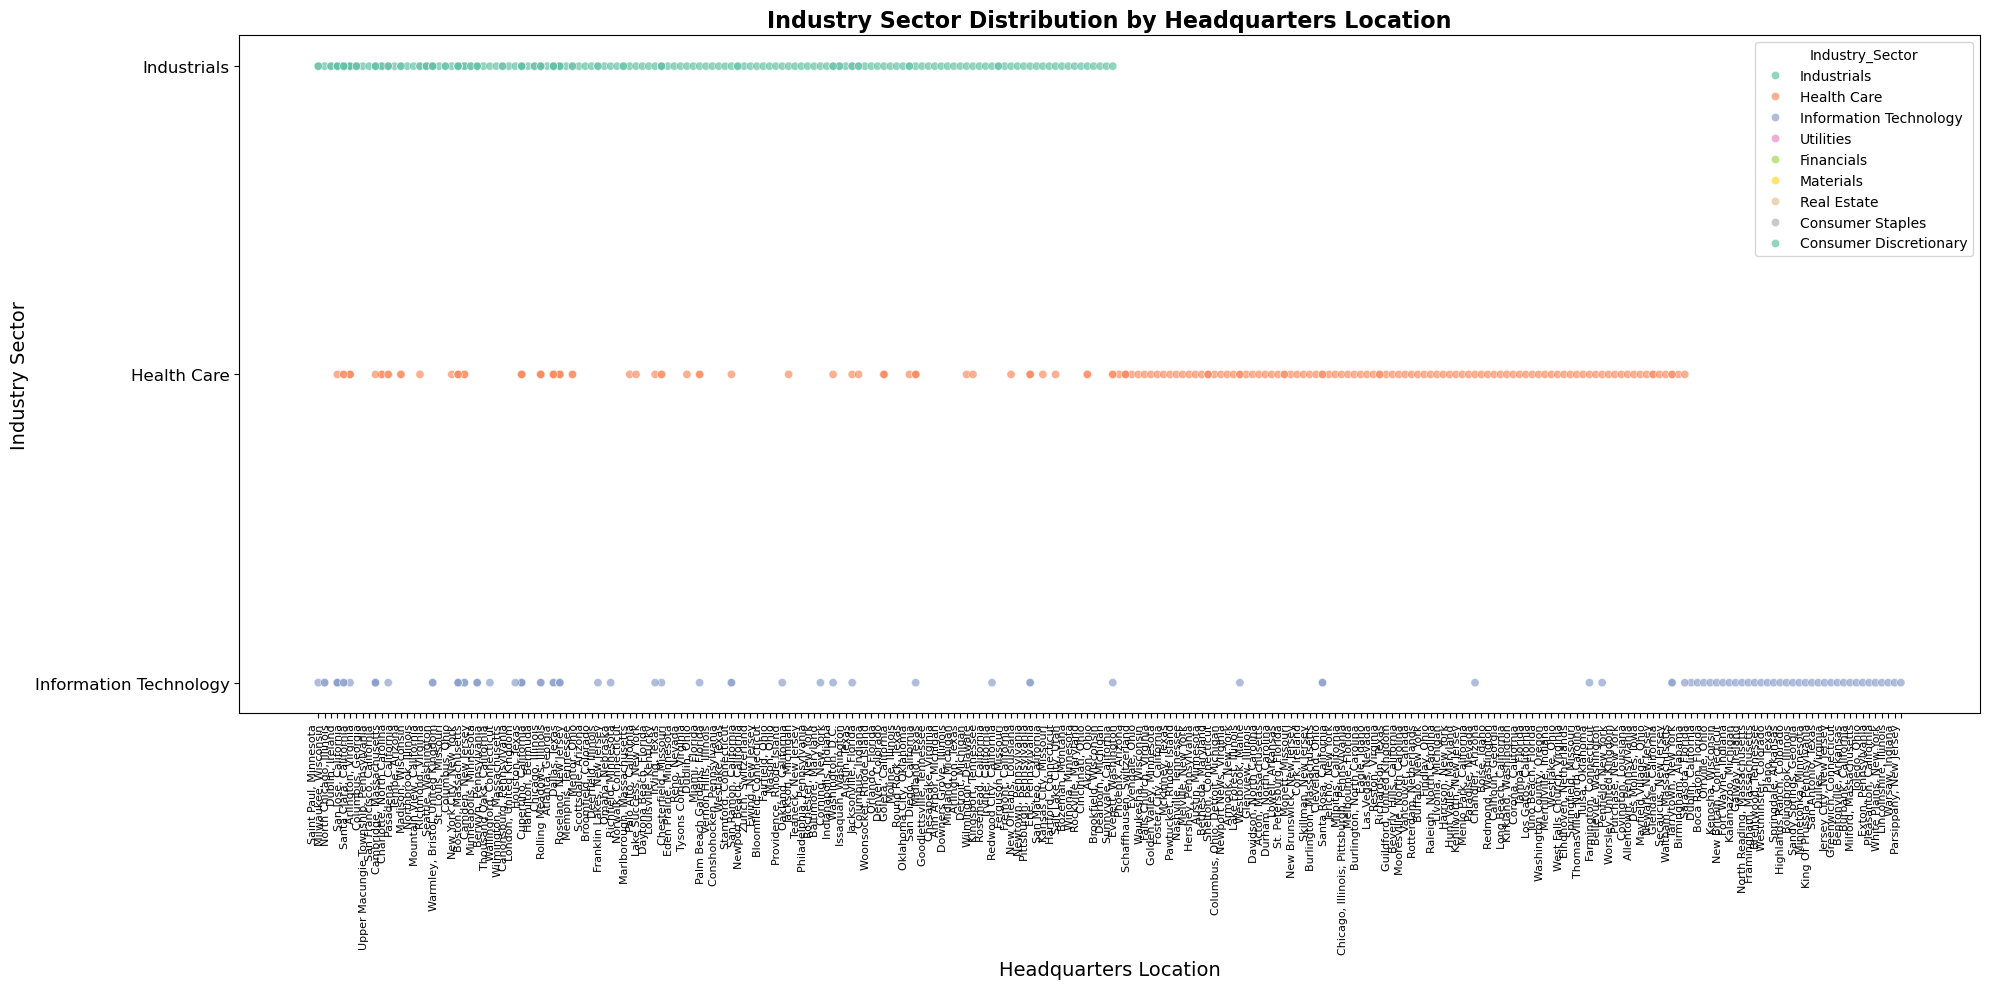

In [140]:

# Increase figure size for better readability
plt.figure(figsize=(20, 10))

# Create scatter plot with adjusted labels and color coding
sns.scatterplot(
    x=wiki_data["Headquarters"], 
    y=final_data["Industry_Sector"], 
    hue=final_data["Industry_Sector"], 
    alpha=0.7, 
    palette="Set2"
)

# Improve label readability
plt.xticks(rotation=90, ha="right", fontsize=8)  # Rotate x-axis labels for better spacing
plt.yticks(fontsize=12)  # Increase font size for industry sector labels
plt.xlabel("Headquarters Location", fontsize=14)
plt.ylabel("Industry Sector", fontsize=14)
plt.title("Industry Sector Distribution by Headquarters Location", fontsize=16, fontweight="bold")

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show plot
plt.show()


# Project Summary & Ethical Implications
What I Learned from This Project
Key Learnings from the Project
This project involved data wrangling, integration, and visualization using three datasets—Kaggle financials, 
Wikipedia metadata and Alpha Vantage API stock market data—to analyze S&P 500 companies. 
The process required extensive data cleaning, resolving inconsistencies, ensuring uniform formatting, 
and conducting SQL joins to merge the datasets into a structured format. 
The final consolidated dataset enabled insightful visualizations that highlighted stock market trends, sector-wise performance, 
and financial indicators across different companies.

Through this experience, I learned how to:

Handle multi-source data integration challenges (column misalignment, missing entries, API restrictions).

Perform fuzzy matching techniques to align company names.

Create meaningful financial metrics such as Daily Market Movement, Price Performance Index, and Sector-Average PE Ratio.

Store and manipulate data efficiently in an SQL database for structured queries and analysis.

# Changes Made to the Data
Throughout the project, multiple transformations were performed to enhance data usability:

**Column Renaming & Standardization**

Adjusted naming conventions across Kaggle, Wikipedia, and API datasets for consistency.

**Handling Missing Values**

Used median imputation for Market Cap inconsistencies and mean replacement for missing PE Ratios.

**Data Formatting**

Converted Market Cap to readable numeric formatting (removing scientific notation).

**Merging Datasets**

Unified financial metrics and company metadata using SQL joins, ensuring proper data alignment.

**Feature Engineering**

Created new variables like Dividend-to-Earnings Ratio and Volume-to-Market Cap Ratio for deeper insights.

**Legal & Regulatory Considerations**
Data used in this project comes from publicly available sources, 
but it carries ethical and legal implications:

**Wikipedia & Kaggle Data:**

Public domain, but subject to data accuracy concerns (as they are community-maintained).

**Alpha Vantage API Usage:**

Must follow terms of service and rate limits to prevent misuse.

SEC & Financial Reporting Standards:

Since the dataset includes financial information, any interpretation should align 
with investment regulations 
(avoiding misleading financial advice).

**Potential Risks from Data Transformations**
Misalignment of Historical vs. Real-Time Data

The Kaggle dataset contains historical financial metrics, whereas the Alpha Vantage API delivers 
real-time market data. 
Merging these sources without careful synchronization may introduce inaccuracies.

**Data Bias in Company Representation**

The datasets favor large-cap companies with abundant available data, potentially neglecting smaller firms.

Fuzzy Matching Errors

Some companies may have multiple ticker symbols due to mergers, leading to incorrect mapping across datasets.

**Use in Investment Decisions**

The analysis should not be interpreted as financial advice, as stock prices are dynamic 
and influenced by external factors.

**Assumptions Made in Data Cleaning & Transformation**
Several assumptions were necessary:

Company names with slight variations were considered matches using fuzzy text processing.

Market Cap median imputation assumes a normal distribution of financial values.

API stock data was considered valid despite potential data gaps due to rate limitations.

**Credibility of Data Sources**
**To ensure reliability:**

Wikipedia data was cross-checked with Kaggle financials to minimize discrepancies.

API financial data was verified by comparing extracted stock prices with external finance sources.

SQL-based integration ensured structured merging without duplicate data conflicts.

Ethical Acquisition & Handling of Data
All datasets were obtained through publicly available sources, adhering to ethical principles:

No personal or sensitive financial information was extracted.

Data transformations aimed at accuracy and transparency (not manipulation for misleading conclusions).

Open-source data integrity checks were conducted to ensure responsible analysis.

**Mitigating Ethical Concerns**
Transparency in Data Cleaning Methods

Clearly documenting assumptions, imputed values, and merge strategies ensures 
that findings are traceable and reproducible.

Cross-validation with External Financial Sources

Comparing API-based stock prices with official records helps confirm accuracy.

Preventing Misleading Financial Interpretation

Emphasizing that insights are informational rather than predictive analysis avoids unethical financial influence.

Handling Bias in Industry Representation

Ensuring balanced sector analysis rather than favoring large-cap companies improves dataset fairness.

# Final Thoughts
This project reinforced the importance of structured data integration, careful cleansing, and ethical considerations 
in financial analysis. While merging multi-source data improves analytical depth, 
it also requires responsible handling to mitigate biases and inaccuracies. 
Ensuring transparent methodologies and proper verification guarantees that findings remain valid, ethical, and legally sound.